# Определение перспективного тарифа для телеком компании

Нам известно, что клиентам предлагают два тарифных плана: **«Смарт» и «Ультра»**. Чтобы скорректировать рекламный бюджет, необходимо понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов:**
* Тариф **«Смарт»**
    * Ежемесячная плата: **550 рублей**
    * Включено **500 минут** разговора, **50 сообщений** и **15 Гб** интернет-трафика
    * Стоимость услуг сверх тарифного пакета:
    * минута разговора: **3 рубля**
    * сообщение: **3 рубля**
    * 1 Гб интернет-трафика: **200 рублей**
    

* Тариф **«Ультра»**
    * Ежемесячная плата: **1950 рублей**
    * Включено **3000 минут** разговора, **1000 сообщений** и **30 Гб** интернет-трафика
    * Стоимость услуг сверх тарифного пакета:
    * минута разговора: **1 рубль**
    * сообщение: **1 рубль**
    * 1 Гб интернет-трафика: **150 рублей**

*Примечание: оператор всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*

## Общая информация о данных в работе

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
sns.set_style("darkgrid")


In [ ]:
df_users = pd.read_csv('/content/users.csv')
df_calls = pd.read_csv('/content/calls.csv')
df_messages = pd.read_csv('/content/messages.csv')
df_internet = pd.read_csv('/content/internet.csv', index_col='Unnamed: 0')
df_tariffs = pd.read_csv('/content/tariffs.csv')

### Таблица users (информация о пользователях):

In [ ]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


**Таблица users (информация о пользователях):**

- **user_id** — уникальный идентификатор пользователя
- **first_name** — имя пользователя
- **last_name** — фамилия пользователя
- **age** — возраст пользователя (годы)
- **reg_date** — дата подключения тарифа (день, месяц, год)
- **churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- **city** — город проживания пользователя
- **tariff** — название тарифного плана

Сет данных содержит информацию о пользователе, месте проживания, дате регистрации, о тарифе, о дате окончания пользования услугами оператора, возрасте. Пропуски наблюдаются в столбце `churn_date`. Проверим дубликаты: 

In [ ]:
df_users.duplicated().sum()

0

In [ ]:
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


Дубликатов нет. Аномальных значений на первый взгляд нет. Столбец `reg_date` необходимо привести к `datetime` - формату

### Таблица calls (информация о звонках):

In [ ]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


**Таблица calls (информация о звонках):**

- **id** — уникальный номер звонка
- **call_date** — дата звонка
- **duration** — длительность звонка в минутах
- **user_id** — идентификатор пользователя, сделавшего звонок

In [ ]:
df_calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


Сет данных содержит информацию о пользователе (user_id), дате и продолжительности звонка. Дату в столбце `call_date` необходимо привести к формату `datetime`. Обнаружена аномалия - минимальное значение для продолжительности звонка - 0 минут, что не вяжется с принципами работы оператора.   
Проверим дубликаты:

In [ ]:
df_calls.duplicated().sum()

0

Дубликатов не обнаружено

### Таблица messages (информация о сообщениях):

In [ ]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


**Таблица messages (информация о сообщениях):**

- **id** — уникальный номер сообщения
- **message_date** — дата сообщения
- **user_id** — идентификатор пользователя, отправившего сообщение

In [ ]:
df_messages.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


Сет данных содержит информацию о пользователе (user_id), дате отправки сообщения и id сообщения. Дату в столбце `message_date` необходимо привести к формату datetime. 
Проверим дубликаты:

In [ ]:
df_messages.duplicated().sum()

0

Дубликатов не обнаружено

### Таблица internet (информация об интернет-сессиях):


In [ ]:
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [ ]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


**Таблица internet (информация об интернет-сессиях):**
    
- **id** — уникальный номер сессии
- **mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)
- **session_date** — дата интернет-сессии


In [ ]:
df_internet.describe().T

,count,mean,std,min,25%,50%,75%,max
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


Сет данных содержит информацию о пользователе (`user_id`), дате и продолжительности интернет сессии и id сессии. Дату в столбце `session_date` необходимо привести к формату `datetime`. Обнаружена аномалия - минимальное значение для использованных МБ траффика - `0`, что не вяжется с принципами работы оператора, если сессия состоялась.
Проверим дубликаты:

In [ ]:
df_internet.duplicated().sum()

0

Дубликатов не обнаружено

### Таблица tariffs (информация о тарифах):

In [ ]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Таблица tariffs (информация о тарифах):**

- **tariff_name** — название тарифа
- **rub_monthly_fee** — ежемесячная абонентская плата в рублях
- **minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату
- **messages_included** — количество сообщений в месяц, включённых в абонентскую плату
- **mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- **rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то - со 101 минуты будет взиматься плата)
- **rub_per_message** — стоимость отправки сообщения сверх тарифного пакета
- **rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Вывод

В нашем распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. В данных дубликатов не наблюдается.  

- Пропуски есть только в дата сете **df_users**:  
столбец: **churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
Отсутвие даты - скорее означает, что обслуживание не завершено, клиент еще пользуется услугами оператора.  **Пропуски не трогаем**

- Необходимо изменить тип данных:
 
    - reg_date - на datetime в df_users
    - call_date - на datetime в df_calls
    - session_date - на datetime в df_internet
    - message_date - на datetime в df_messages


С учетом примечания(оператор всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута): 
- Округляем в большую сторону до минуты все звонки
- Округляем в большую сторону до мегабайта весь трафик по каждой сессии 
- `mb_used` необходимо округлить в большую сторону и привести к целоцисленным
- В `df.internet` мегабайты перевести в гигабайты
- `duration` необходимо привести в большую сторону и привести к целоцисленным 
- Добавим столбцы месяца 
- Обратили внимание, что в сетах со временем разговоров и интернет траффика - минимальное значение 0, что не вяжется с принципами работы оператора. Необходимо изучить данные аномалии и принять решение, что будем с ними делать
- Необходимо объединить таблицы для анализа



## Подготовка данных к анализу




Перейдем к обработке данных. Сконцетрируемся на замене значений. Окончательные замены произведем после объединения таблиц

### Обработка столбцов с датами

In [ ]:
# Словарь с месяцами для удобства восприятия в будущем:

dict_of_months = {
    1: 'Январь', 2: 'Февраль', 3: 'Март', 
    4: 'Апрель', 5: 'Май', 6: 'Июнь', 
    7: 'Июль', 8:'Август', 9:'Сентябрь', 
    10:'Октябрь', 11:'Ноябрь', 12:'Декабрь'
}

#функия замены столбцов и добавления двух новых к датафрейму:

def month_season(dframes):
    for df in dframes:
        for column in df.columns:
            if 'date' in column and column != 'churn_date':
                df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
                df['month'] = df[column].apply(lambda x: x.month)
                df['year'] = df[column].apply(lambda x: x.year)
                df['month_name'] = df['month'].map(dict_of_months)

Приведем формат дат к `datetime` и добавим два новых столбца

In [ ]:
month_season([df_users, df_calls, 
              df_messages, df_internet]
            )

In [ ]:
print('Список уникальных значений столбца year: ', df_users['year'].unique())
df_users.head()

Список уникальных значений столбца year:  [2018]


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,year,month_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2018,Май
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,2018,Ноябрь
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,2018,Июнь
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,2018,Август
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,2018,Май


In [ ]:
df_calls.head()

,id,call_date,duration,user_id,month,year,month_name
0,1000_0,2018-07-25,0.00,1000,7,2018,Июль
1,1000_1,2018-08-17,0.00,1000,8,2018,Август
2,1000_2,2018-06-11,2.85,1000,6,2018,Июнь
3,1000_3,2018-09-21,13.80,1000,9,2018,Сентябрь
4,1000_4,2018-12-15,5.18,1000,12,2018,Декабрь


In [ ]:
df_messages.head()

,id,message_date,user_id,month,year,month_name
0,1000_0,2018-06-27,1000,6,2018,Июнь
1,1000_1,2018-10-08,1000,10,2018,Октябрь
2,1000_2,2018-08-04,1000,8,2018,Август
3,1000_3,2018-06-16,1000,6,2018,Июнь
4,1000_4,2018-12-05,1000,12,2018,Декабрь


### Обработка `df_internet`

In [ ]:
df_internet.head()

,id,mb_used,session_date,user_id,month,year,month_name
0,1000_0,112.95,2018-11-25,1000,11,2018,Ноябрь
1,1000_1,1052.81,2018-09-07,1000,9,2018,Сентябрь
2,1000_2,1197.26,2018-06-25,1000,6,2018,Июнь
3,1000_3,550.27,2018-08-22,1000,8,2018,Август
4,1000_4,302.56,2018-09-24,1000,9,2018,Сентябрь


Построим диаграмму для данного столбца, чтобы увидеть разброс значений:

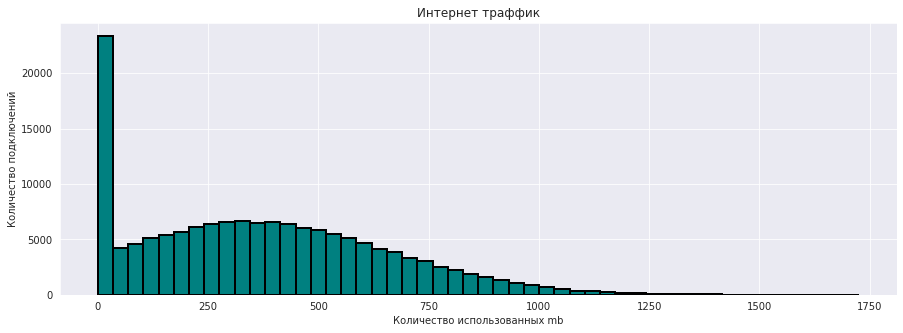

In [ ]:
df_internet['mb_used'].plot(kind='hist', figsize=(15,5),
                            grid=True, color='teal', 
                            edgecolor='black', linewidth=2, bins=50
)
plt.title('Интернет траффик')
plt.xlabel('Количество использованных mb')
plt.ylabel('Количество подключений')
plt.show()

In [ ]:
internet_0_1 = df_internet.query('mb_used > 0 and mb_used < 1')['mb_used'].count()
internet_0 = df_internet.query('mb_used == 0')['mb_used'].count()

print('Интернет траффик от 0 мб до 1 мб:', internet_0_1)
print('Количество нулевых значений траффика:', internet_0)
print('Всего случаев подключения: ', df_internet['mb_used'].count())
print('Процент нулевых значений траффика: {:.2%}'.format(internet_0/df_internet['mb_used'].count()))

Интернет траффик от 0 мб до 1 мб: 101
Количество нулевых значений траффика: 19598
Всего случаев подключения:  149396
Процент нулевых значений траффика: 13.12%


Исходя из полученной информации, можно сделать вывод о том, что нулевые значения появляются в том случае, когда абонент не использовал интернет трафик в течение месяца или размер трафика был близок к 0 и не превышал нескольких килобайт и это не было зафиксировано, следовательно такие значения не несут в себе полезной нагрузки для дальнейшего анализа и от них можно избавиться

In [ ]:
df_internet = df_internet.query('mb_used > 0').copy()
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            129798 non-null  object        
 1   mb_used       129798 non-null  float64       
 2   session_date  129798 non-null  datetime64[ns]
 3   user_id       129798 non-null  int64         
 4   month         129798 non-null  int64         
 5   year          129798 non-null  int64         
 6   month_name    129798 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 7.9+ MB


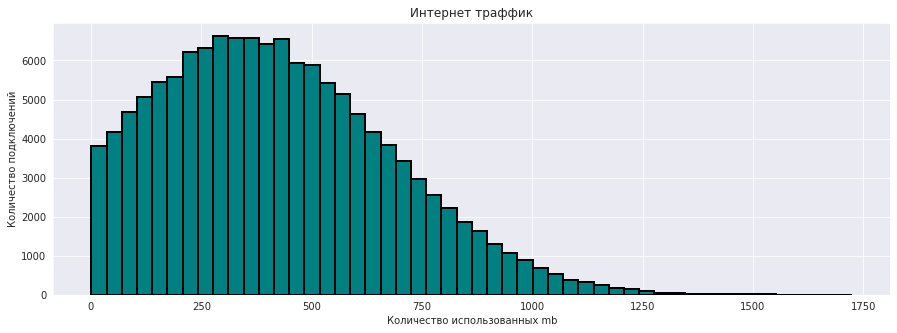

In [ ]:
df_internet['mb_used'].plot(
    kind='hist', figsize=(15,5), 
    grid=True, color='teal', 
    edgecolor='black', linewidth=2, bins=50
)
plt.title('Интернет траффик')
plt.xlabel('Количество использованных mb')
plt.ylabel('Количество подключений')
plt.show()

Строки удалены. Также необходимо добавить столбец с траффиком в Гигабайтах для удобства нашей работы:

In [ ]:
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])
df_internet['gb_used'] = df_internet['mb_used'].apply(lambda x: x/1024)

df_internet.head()

,id,mb_used,session_date,user_id,month,year,month_name,gb_used
0,1000_0,113.0,2018-11-25,1000,11,2018,Ноябрь,0.110352
1,1000_1,1053.0,2018-09-07,1000,9,2018,Сентябрь,1.028320
2,1000_2,1198.0,2018-06-25,1000,6,2018,Июнь,1.169922
3,1000_3,551.0,2018-08-22,1000,8,2018,Август,0.538086
4,1000_4,303.0,2018-09-24,1000,9,2018,Сентябрь,0.295898


### Обработка `df_calls`

Построим гистограмму значений для продолжительности звонков:

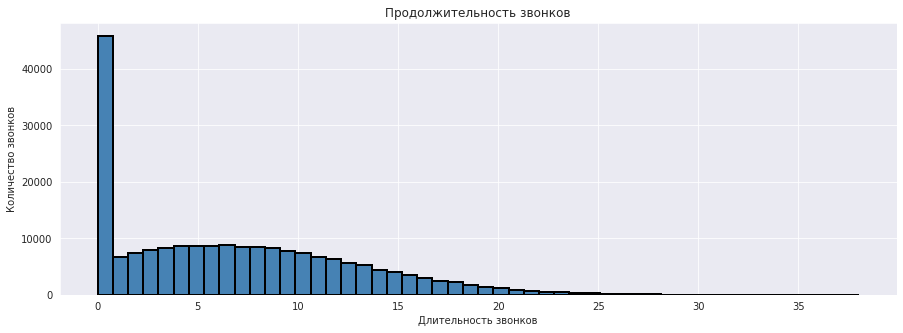

In [ ]:
df_calls['duration'].plot(kind='hist', figsize=(15,5),
                          grid=True, color='steelblue', 
                          edgecolor='black', linewidth=2, bins=50  
                         ) 

plt.title('Продолжительность звонков')
plt.xlabel('Длительность звонков')
plt.ylabel('Количество звонков')
plt.show()

In [ ]:
calls_0_1 = df_calls.query('duration > 0 and duration < 1')['duration'].count()
calls_0 = df_calls.query('duration == 0')['duration'].count()

print('Разговоры от 0 до 1 минуты:', calls_0_1)
print('Количество нулевых значений:', calls_0)
print('Всего звонков: ', df_calls['duration'].count())
print('Процент нулевых звонков: {:.2%}'.format(calls_0/df_calls['duration'].count()))

Разговоры от 0 до 1 минуты: 8314
Количество нулевых значений: 39613
Всего звонков:  202607
Процент нулевых звонков: 19.55%


Исходя из полученной информации, можно сделать вывод, что нулевые значения соответствуют тем звонкам, где абонент не ответил на вызов (как в случае исходящих звонков, так и исходящих), и, соответственно, длительность разговора составила 0 минут и секунд. Нулевые строки удаляем:

In [ ]:
df_calls = df_calls.query('duration > 0').copy()
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          162994 non-null  object        
 1   call_date   162994 non-null  datetime64[ns]
 2   duration    162994 non-null  float64       
 3   user_id     162994 non-null  int64         
 4   month       162994 non-null  int64         
 5   year        162994 non-null  int64         
 6   month_name  162994 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 9.9+ MB


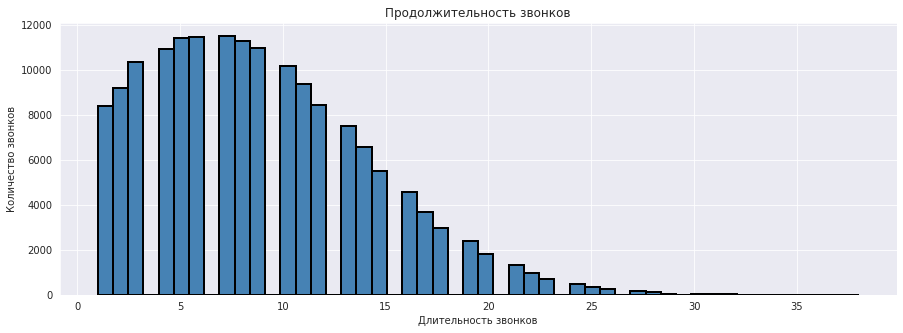

In [ ]:
df_calls['duration'].plot(kind='hist', figsize=(15,5),
                          grid=True, color='steelblue',
                          edgecolor='black', linewidth=2, bins=50
                      
)

plt.title('Продолжительность звонков')
plt.xlabel('Длительность звонков')
plt.ylabel('Количество звонков')
plt.show()

### Изучение данных по месяцам

Посмотрим следующую информацию:

- количество сделанных звонков и израсходованных минут разговора по месяцам;  
- количество отправленных сообщений по месяцам;  
- объем израсходованного интернет-трафика по месяцам;    

Для этого построим столбчатую диаграмму для трех параметров: Количество звонков, количество SMS, количество интернет-сессий

In [ ]:
#напишем функцию для построения диаграммы

def plotting_month(dataframes_list, query=None):
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    
    list_of_colors = ['steelblue', 'skyblue', 'cyan']

    df_names_for_legend = [
        'Количество звонков', 
        'Количество SMS', 'Количество интернет-сессий'
        ]
    legend_list = []

    for i in range(len(dataframes_list)):
        grouped_df = dataframes_list[i]
        grouped_df_p = grouped_df.groupby('month')['user_id'].count().reset_index()

        plot = grouped_df_p.plot(
            x='month', y='user_id', 
            kind='bar', edgecolor='black', 
            color=list_of_colors[i],
            ax=ax, width=0.08, position=i
)
        legend_list.append(df_names_for_legend[i])
    
    plt.xticks(
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
        [
        'Январь', 'Февраль','Март', 'Апрель', 
        'Май', 'Июнь', 'Июль','Август', 
        'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'
        ], rotation=20
)
    
    ax.legend(legend_list)
    plt.title('Услуги оператора по месяцам для выборки')
    plt.xlabel('Месяц года')
    plt.ylabel('Количество')
    plt.show()
    
    


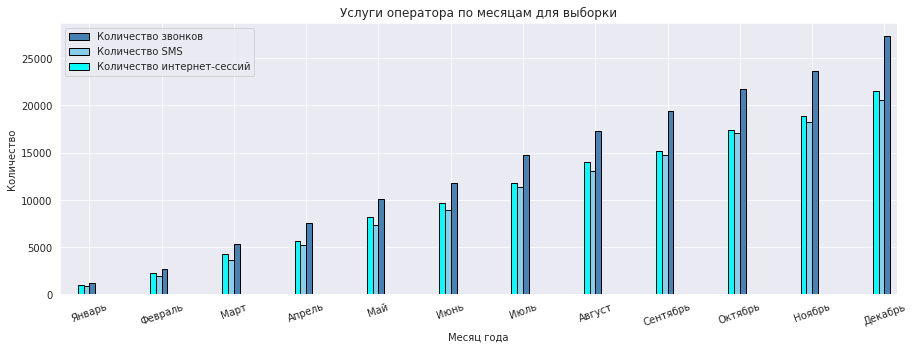

In [ ]:
plotting_month([df_calls, df_messages, 
              df_internet]
)

### Формирование общей таблицы

Сгруппируем таблицу звонков по месяцу и пользователю, найдем продолжительность разговора и количество:

In [ ]:
calls_grouped = df_calls.groupby(['user_id','month_name']).agg({'duration': ['sum','count']}).reset_index()
calls_grouped.columns = ['user_id', 'month_name','duration_of_calls', 'quantity_of_calls'] 
calls_grouped.head(15)


,user_id,month_name,duration_of_calls,quantity_of_calls
0,1000,Август,408.0,42
1,1000,Декабрь,333.0,38
2,1000,Июль,340.0,41
3,1000,Июнь,172.0,28
4,1000,Май,159.0,17
5,1000,Ноябрь,338.0,37
6,1000,Октябрь,350.0,44
7,1000,Сентябрь,466.0,46
8,1001,Декабрь,414.0,47
9,1001,Ноябрь,430.0,45


Сгруппируем таблицу пользования интернет траффиком по месяцу и пользователю, найдем количество использованных Гигабайт:

In [ ]:
internet_grouped = df_internet.groupby(['user_id','month_name']).agg({'gb_used': 'sum'}).reset_index()
internet_grouped.columns = ['user_id', 'month_name','gb_used_total'] 
internet_grouped.head(15)


,user_id,month_name,gb_used_total
0,1000,Август,13.740234
1,1000,Декабрь,9.596680
2,1000,Июль,13.687500
3,1000,Июнь,22.711914
4,1000,Май,2.203125
5,1000,Ноябрь,14.421875
6,1000,Октябрь,14.372070
7,1000,Сентябрь,14.239258
8,1001,Декабрь,13.723633
9,1001,Ноябрь,18.019531


Сгруппируем таблицу отправки sms-сообщений по месяцу и пользователю, найдем количество отправленных сообщений:

In [ ]:
messages_grouped = df_messages.groupby(['user_id','month_name']).agg({'id':'count'}).reset_index()
messages_grouped.columns = ['user_id', 'month_name','quantity_of_sms'] 
messages_grouped.head(15)

,user_id,month_name,quantity_of_sms
0,1000,Август,81
1,1000,Декабрь,70
2,1000,Июль,75
3,1000,Июнь,60
4,1000,Май,22
5,1000,Ноябрь,58
6,1000,Октябрь,73
7,1000,Сентябрь,57
8,1002,Август,13
9,1002,Декабрь,12


Сформируем общую таблицу:

In [ ]:
mobile_customers = calls_grouped.merge(messages_grouped,  how = 'outer', 
                                       on = ['user_id', 'month_name']).merge(internet_grouped,  how = 'outer', 
                                       on = ['user_id', 'month_name']).merge(df_users[['user_id', 'tariff','city']], how = 'left', 
                                       on = 'user_id').sort_values(
                                                                   by='user_id').reset_index(drop=True
                                                                   )


print('Количество уникальных пользователей в итоговой таблице: ', 
      len(mobile_customers['user_id'].unique()), 'человек')
mobile_customers.head(15)

Количество уникальных пользователей в итоговой таблице:  498 человек


,user_id,month_name,duration_of_calls,quantity_of_calls,quantity_of_sms,gb_used_total,tariff,city
0,1000,Август,408.0,42.0,81.0,13.740234,ultra,Краснодар
1,1000,Декабрь,333.0,38.0,70.0,9.596680,ultra,Краснодар
2,1000,Июль,340.0,41.0,75.0,13.687500,ultra,Краснодар
3,1000,Июнь,172.0,28.0,60.0,22.711914,ultra,Краснодар
4,1000,Май,159.0,17.0,22.0,2.203125,ultra,Краснодар
5,1000,Ноябрь,338.0,37.0,58.0,14.421875,ultra,Краснодар
6,1000,Октябрь,350.0,44.0,73.0,14.372070,ultra,Краснодар
7,1000,Сентябрь,466.0,46.0,57.0,14.239258,ultra,Краснодар
8,1001,Ноябрь,430.0,45.0,NaN,18.019531,smart,Москва
9,1001,Декабрь,414.0,47.0,NaN,13.723633,smart,Москва


In [ ]:
mobile_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            3214 non-null   int64  
 1   month_name         3214 non-null   object 
 2   duration_of_calls  3168 non-null   float64
 3   quantity_of_calls  3168 non-null   float64
 4   quantity_of_sms    2717 non-null   float64
 5   gb_used_total      3201 non-null   float64
 6   tariff             3214 non-null   object 
 7   city               3214 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 201.0+ KB


Проверим пропуски в новой таблице:

In [ ]:
mobile_customers.isna().mean().sort_values(ascending=False)

quantity_of_sms      0.154636
quantity_of_calls    0.014312
duration_of_calls    0.014312
gb_used_total        0.004045
city                 0.000000
tariff               0.000000
month_name           0.000000
user_id              0.000000
dtype: float64

Ожидаемо, что пропуски есть в столбцах количества `sms`, продолжительности и количестве звонков, использованном трафике. Так как изначально пропусков не наблюдалось - это означает, что абоненты с пропусками в тех или иных столбцах не пользовались данным видом связи. Пропуски заменим на `0`:

In [ ]:
mobile_customers = mobile_customers.fillna(0)
mobile_customers.isna().mean().sort_values(ascending=False)

city                 0.0
tariff               0.0
gb_used_total        0.0
quantity_of_sms      0.0
quantity_of_calls    0.0
duration_of_calls    0.0
month_name           0.0
user_id              0.0
dtype: float64

### Помесячная выручка с каждого пользователя

Обратимся к таблице с тарифамию Необходимо привести количество Мегабайт в Гигабайты, для удобства подсчетов

In [ ]:
df_tariffs ['gb_per_month_included'] = df_tariffs['mb_per_month_included'].apply(lambda x: x/1024)
df_tariffs['gb_per_month_included'] = np.ceil(df_tariffs['gb_per_month_included']).astype(int)
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


Посчитаем и добавим в таблицу помесячную выручку с каждого пользователя. Для начала напишем функции, обращаться будем к таблице с тарифами

In [ ]:
# функция для нахождения превышения разговоров

def calls_over_lim(row):
    if row['tariff'] == 'smart':
        result = row['duration_of_calls'] - df_tariffs.loc[0, 'minutes_included']
        return np.where(result > 0, result, 0)
    else:
        result = row['duration_of_calls'] - df_tariffs.loc[1, 'minutes_included']
        return np.where(result > 0, result, 0)

# функция для нахождения превышения sms-сообщений

def sms_over_lim(row):
    if row['tariff'] == 'smart':
        i=0
    else:
        i=1
    result = row['quantity_of_sms'] - df_tariffs.loc[i, 'messages_included']
    return np.where(result > 0, result, 0)
    
# функция для нахождения превышения интернет-траффика

def web_over_lim(row):
    if row['tariff'] == 'smart':
        result = row['gb_used_total'] - df_tariffs.loc[0, 'gb_per_month_included']
        return np.where(result > 0, result, 0)
    else:
        result = row['gb_used_total'] - df_tariffs.loc[1, 'gb_per_month_included']
        return np.where(result > 0, result, 0)
    
# функция для нахождения размера превышения по тарифу

def month_overcome(row):
    total_income = 0
    if row['tariff'] == 'smart':
        total_income += np.ceil(row['minutes_over_plan']) * df_tariffs.loc[0, 'rub_per_minute']
        total_income += row['sms_over_plan'] * df_tariffs.loc[0, 'rub_per_message']
        total_income += np.ceil(row['gb_over_plan']) * df_tariffs.loc[0, 'rub_per_gb']
        return total_income
    
    else:
        total_income += np.ceil(row['minutes_over_plan']) * df_tariffs.loc[1, 'rub_per_minute']
        total_income += row['sms_over_plan'] * df_tariffs.loc[1, 'rub_per_message']
        total_income += np.ceil(row['gb_over_plan']) * df_tariffs.loc[1, 'rub_per_gb']
        return total_income
    
# функция для нахождения общего поступления от клиента в рамках всех услуг

def revenue(row):
    if row['tariff'] == 'smart':
        result = row['monthly_overcome'] + df_tariffs.loc[0, 'rub_monthly_fee']
        return np.where(result > 0, result, 0)
    else:
        result = row['monthly_overcome'] + df_tariffs.loc[1, 'rub_monthly_fee']
        return np.where(result > 0, result, 0)    

In [ ]:
#применим функцию

mobile_customers ['minutes_over_plan'] = mobile_customers.apply(calls_over_lim, axis=1)
mobile_customers ['sms_over_plan'] = mobile_customers.apply(sms_over_lim, axis=1)
mobile_customers['gb_over_plan'] = mobile_customers.apply(web_over_lim, axis=1)
mobile_customers['monthly_overcome'] = mobile_customers.apply(month_overcome, axis=1)
mobile_customers ['monthly_revenue'] = mobile_customers.apply(revenue, axis=1)


mobile_customers.info()
mobile_customers.head(10)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            3214 non-null   int64  
 1   month_name         3214 non-null   object 
 2   duration_of_calls  3214 non-null   float64
 3   quantity_of_calls  3214 non-null   float64
 4   quantity_of_sms    3214 non-null   float64
 5   gb_used_total      3214 non-null   float64
 6   tariff             3214 non-null   object 
 7   city               3214 non-null   object 
 8   minutes_over_plan  3214 non-null   object 
 9   sms_over_plan      3214 non-null   object 
 10  gb_over_plan       3214 non-null   object 
 11  monthly_overcome   3214 non-null   float64
 12  monthly_revenue    3214 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 326.5+ KB


,user_id,month_name,duration_of_calls,quantity_of_calls,quantity_of_sms,gb_used_total,tariff,city,minutes_over_plan,sms_over_plan,gb_over_plan,monthly_overcome,monthly_revenue
0,1000,Август,408.0,42.0,81.0,13.740234,ultra,Краснодар,0.0,0.0,0.0,0.0,1950.0
1,1000,Декабрь,333.0,38.0,70.0,9.596680,ultra,Краснодар,0.0,0.0,0.0,0.0,1950.0
2,1000,Июль,340.0,41.0,75.0,13.687500,ultra,Краснодар,0.0,0.0,0.0,0.0,1950.0
3,1000,Июнь,172.0,28.0,60.0,22.711914,ultra,Краснодар,0.0,0.0,0.0,0.0,1950.0
4,1000,Май,159.0,17.0,22.0,2.203125,ultra,Краснодар,0.0,0.0,0.0,0.0,1950.0
5,1000,Ноябрь,338.0,37.0,58.0,14.421875,ultra,Краснодар,0.0,0.0,0.0,0.0,1950.0
6,1000,Октябрь,350.0,44.0,73.0,14.372070,ultra,Краснодар,0.0,0.0,0.0,0.0,1950.0
7,1000,Сентябрь,466.0,46.0,57.0,14.239258,ultra,Краснодар,0.0,0.0,0.0,0.0,1950.0
8,1001,Ноябрь,430.0,45.0,0.0,18.019531,smart,Москва,0.0,0.0,3.01953125,800.0,1350.0
9,1001,Декабрь,414.0,47.0,0.0,13.723633,smart,Москва,0.0,0.0,0.0,0.0,550.0


В итоговой таблице, которую возьмем в анализ приведем часть столбцов к целочисленным значениям:

In [ ]:
columns_to_int = [
    'duration_of_calls', 'quantity_of_calls', 
    'quantity_of_sms', 'minutes_over_plan', 
    'sms_over_plan', 'gb_over_plan', 'monthly_revenue'
    ]

for column in columns_to_int:
     mobile_customers[column] = mobile_customers[mobile_customers[column].notna()][column].astype('int64')

mobile_customers.info()
mobile_customers.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            3214 non-null   int64  
 1   month_name         3214 non-null   object 
 2   duration_of_calls  3214 non-null   int64  
 3   quantity_of_calls  3214 non-null   int64  
 4   quantity_of_sms    3214 non-null   int64  
 5   gb_used_total      3214 non-null   float64
 6   tariff             3214 non-null   object 
 7   city               3214 non-null   object 
 8   minutes_over_plan  3214 non-null   int64  
 9   sms_over_plan      3214 non-null   int64  
 10  gb_over_plan       3214 non-null   int64  
 11  monthly_overcome   3214 non-null   float64
 12  monthly_revenue    3214 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 326.5+ KB


,user_id,month_name,duration_of_calls,quantity_of_calls,quantity_of_sms,gb_used_total,tariff,city,minutes_over_plan,sms_over_plan,gb_over_plan,monthly_overcome,monthly_revenue
0,1000,Август,408,42,81,13.740234,ultra,Краснодар,0,0,0,0.0,1950
1,1000,Декабрь,333,38,70,9.596680,ultra,Краснодар,0,0,0,0.0,1950
2,1000,Июль,340,41,75,13.687500,ultra,Краснодар,0,0,0,0.0,1950
3,1000,Июнь,172,28,60,22.711914,ultra,Краснодар,0,0,0,0.0,1950
4,1000,Май,159,17,22,2.203125,ultra,Краснодар,0,0,0,0.0,1950
5,1000,Ноябрь,338,37,58,14.421875,ultra,Краснодар,0,0,0,0.0,1950
6,1000,Октябрь,350,44,73,14.372070,ultra,Краснодар,0,0,0,0.0,1950
7,1000,Сентябрь,466,46,57,14.239258,ultra,Краснодар,0,0,0,0.0,1950
8,1001,Ноябрь,430,45,0,18.019531,smart,Москва,0,0,3,800.0,1350
9,1001,Декабрь,414,47,0,13.723633,smart,Москва,0,0,0,0.0,550


### Вывод

Получили общий дата сет `mobile_customers` на котором можем приступать к анализу. Добавили дополнительные стобцы с перерасходом и месяцем, общей выручкой. Можем приступать непосредственно к анализу и ответить на поставленные вопросы. 


## Анализ данных



### Общий анализ значений выборки

Для начала посмотрим размах и смещение наших данных в предоставленной нам выборке из генеральной совокупности. Для этого построим диаграммы размаха.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



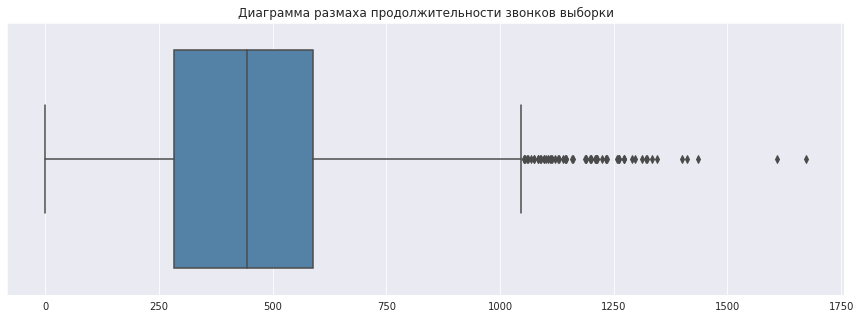

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



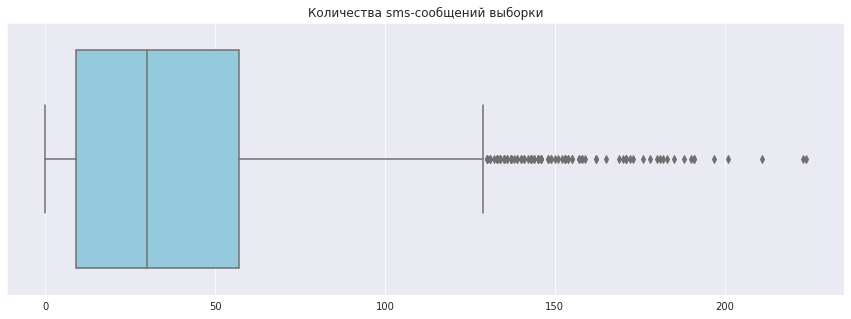

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



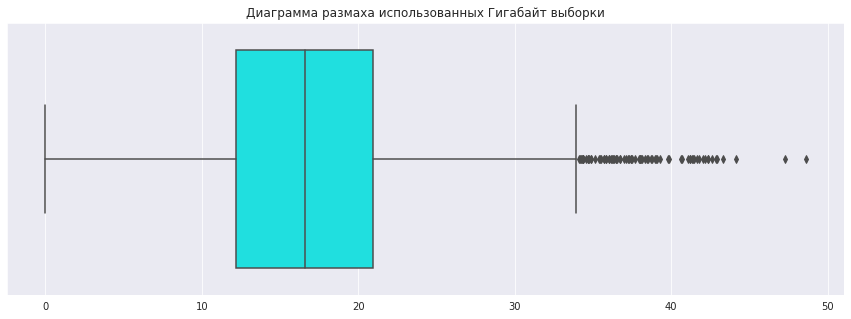

In [ ]:

# создадим списки параметров
columns_list = ['duration_of_calls', 'quantity_of_sms', 'gb_used_total']
title_list = ['Диаграмма размаха продолжительности звонков выборки', 'Количества sms-сообщений выборки', 
              'Диаграмма размаха использованных Гигабайт выборки']

color_list=['steelblue', 'skyblue', 'cyan']

#цикл построения наших графиков с интересующими нас параметрами. 
#xlim зададим через квантиль, чтобы не подбирать значения вручную

for i in range(len(columns_list)):
    q75 = mobile_customers[columns_list[i]].quantile([.75])
    q25 = mobile_customers[columns_list[i]].quantile([.25])
    iqr = q75 - q25
    low_range = q25 - (1.5 * iqr)
    high_range = q75 + (1.5 * iqr)
    plt.figure(figsize=(15, 5))
    sns.boxplot(mobile_customers[columns_list[i]], color=color_list[i])
    plt.xlim = (low_range, high_range)
    plt.title(title_list[i])
    plt.xlabel('')
    plt.show()


Датасет скошен вправо (то есть в сторону положительного направления оси), расстояние между первым квартилем и медианой меньше, чем расстояние между медианой и третьим квартилем. Это ярко выражено на диаграмме размаха для sms-сообщений, у интернет-траффика почти не заметно. Данные стремятся к нормальному распределению. Наличие выбросов говорит о том, что медиана будет давать наиболее точное представление о структуре данных, нежеле среднее, которое будет смещено вправо. При этом значения не сильно различаются, выборка небольшая, критических аномалий не наблюдается. Применять будем среднее для анализа.
  
Посмотрим как распределены пользователи в выборке по тарифам:

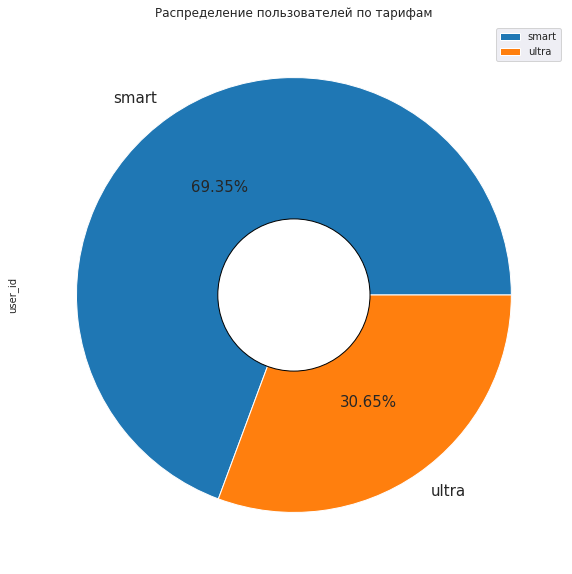

In [ ]:
#получим сводную таблицу по тарифам. Значения зададим по пользователям и пересчитаем их

smart_ultra_cust = mobile_customers.pivot_table(index='tariff', 
                                     values='user_id', 
                                     aggfunc='count'
                                    )


smart_ultra_cust.head()
values = smart_ultra_cust['user_id']

#сделаем подписи

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{p:.2f}%'.format(p=pct)
    return my_autopct

# построим pie диаграмму

smart_ultra_cust.plot(y='user_id', kind='pie', figsize=(15,10), radius=1, 
                      fontsize=15, autopct=make_autopct(values))

# добавим круг, для превращения диаграммы в donut

donut=plt.Circle( (0,0), 0.35, color='white', ec='black')
p=plt.gcf()
p.gca().add_artist(donut)
plt.title('Распределение пользователей по тарифам')

plt.show()



Мы видим, что доля абонентов тарифа Smart выше, что обуславливается более низкой стоимостью абонентской платы, при условии корректности предоставленной нам выборки. Изучим показатели по тарифам:

In [ ]:
mobile_customers_rev = mobile_customers.pivot_table(index='tariff', values='monthly_revenue', aggfunc='mean')
mobile_customers_rev

,monthly_revenue
tariff,
smart,1294.63930
ultra,2071.06599


В среднем, абонент тарифа Smart тратит 1294 рублей, а при условии, что абонентская плата у тарифа 550 рублей - можно сделать вывод, что пользователи тарифа Smart чаще покупают дополнительные услуги, ведь у тарифа Ultra абонентская плата 1950 рубелй, а среднее по выборке составляет 2071 рублей. Посмотрим средний размер покупки доп услуг в месяц:

In [ ]:
mobile_customers_totalover = mobile_customers.pivot_table(index='tariff', values='monthly_overcome', aggfunc='mean')
mobile_customers_totalover

,monthly_overcome
tariff,
smart,744.63930
ultra,121.06599


<div style="border:solid purple 5px; padding: 20px">
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>
    
<h3> Красивый print() <a class="tocSkip"> </h3>

Мы очень часто отлаживаем код и пользуемся функцией `print`. Вывод в одну строку не всегда удобен. К примеру, когда мы делаем запрос серверу и получаем огромный json. Встроенный модуль pprint поможет нам навести красоту. С каждым новым вложением он делает дополнительный отступ и вывод всегда радует глаз. Вот [документация](https://docs.python.org/3/library/pprint.html) на сам модуль. Кстати, мы можем переопределить стандартную функцию print написав `print = pprint.pprint`

Ниже приведен пример кода. Вы можете самостоятельно поэкспериментировать с модулем.

![](https://i.ibb.co/353GvhX/image.png)

Наши предположения подтвердились - пользователи тарифа Smart докупают больше услуг, нежеле абоненты тарифа Ultra. Посмотрим, что чаще всего докупают по тарифам:

In [ ]:
# количество минут сверх плана

mobile_customers_callover = mobile_customers.pivot_table(index='tariff', values='minutes_over_plan', aggfunc='mean')
mobile_customers_callover

,minutes_over_plan
tariff,
smart,41.605653
ultra,0.000000


In [ ]:
# количество sms-сообщений сверх плана

mobile_customers_smsover = mobile_customers.pivot_table(index='tariff', values='sms_over_plan', aggfunc='mean')
mobile_customers_smsover

,sms_over_plan
tariff,
smart,5.79991
ultra,0.00000


In [ ]:
# количество Гигабайт сверх плана

mobile_customers_gbover = mobile_customers.pivot_table(index='tariff', values='gb_over_plan', aggfunc='mean')
mobile_customers_gbover

,gb_over_plan
tariff,
smart,2.425303
ultra,0.671066


In [ ]:
# общая таблица количественных характеристик превышения

(mobile_customers.groupby('tariff').sum()[['minutes_over_plan', 'sms_over_plan', 'gb_over_plan']]).reset_index()

,tariff,minutes_over_plan,sms_over_plan,gb_over_plan
0,smart,92739,12928,5406
1,ultra,0,0,661


Мы видим, что пользователям тарифа Smart чаще всего не хватает интернет траффика. Также пользователям тарифа Smart необходимы дополнительные минуты и сообщений. Посмотрим ситуацию с общим доходом за месяц по тарифам:

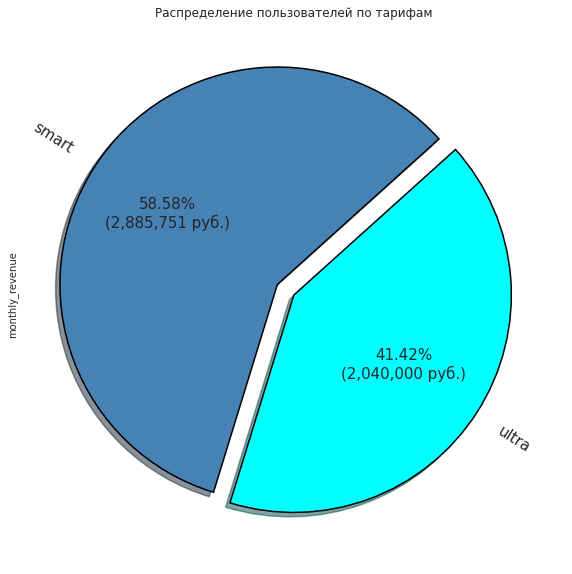

In [ ]:
total_revenue = mobile_customers['monthly_revenue'].sum()


def new_pct(pct):
    value = float(pct/100.*total_revenue)
    return "{:.2f}%\n({:,.0f} руб.)".format(pct, value)


axes = mobile_customers.groupby('tariff')['monthly_revenue'].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                       use_index=False,  
                                                                       startangle=42, figsize=(15,10),
                                                                       autopct=lambda pct: new_pct(pct), 
                                                                       colors=['steelblue', 'cyan'], explode = (.09, 0),
                                                                       wedgeprops={"edgecolor":"k",'linewidth': 1.5, 
                                                                       'linestyle': '-', 'antialiased': True}, shadow=True,
                                                                       rotatelabels=True
                                                                       )

p=plt.gcf()

plt.title('Распределение пользователей по тарифам')

plt.show()


Тарифом Smart пользуется больше людей и люди докупают дополнительные услуги связи. Как следствие, несмотря на тот факт, что абонентская плата тарифа Ultra выше почти в 4 раза, чем тарифа Smart - имеет более высокие показатели поступления денежных средств.

### Анализ времени разговора

Посмотрим значения времени разговора по тарифам методом `describe()`, а также найдем дисперсию и стандартное отклонение:

In [ ]:
smart_mobile = mobile_customers.query('tariff == "smart"')['duration_of_calls'].reset_index(drop=True).round(0)

smart_var = np.var(smart_mobile, ddof=1)

# для удобства решили вынести расчет std отдельно, считаем для выборки, ddof=1

smart_dev = np.std (smart_mobile, ddof=1)


print('Тариф Smart')
print()
print('Дисперсия по вызовам тарифа SMART: {:.2f}'.format(smart_var))
print('Cтандартное отклонение по выборке вызовов тарифа SMART: {:.2f}'.format(smart_dev))
print()
print(smart_mobile.describe().T)



Тариф Smart

Дисперсия по вызовам тарифа SMART: 36219.32
Cтандартное отклонение по выборке вызовов тарифа SMART: 190.31

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: duration_of_calls, dtype: float64


In [ ]:
ultra_mobile = mobile_customers.query('tariff == "ultra"')['duration_of_calls'].reset_index(drop=True).round(0)
ultra_var = np.var(ultra_mobile, ddof=1)
ultra_dev = np.std (ultra_mobile, ddof=1)


print('Тариф Ultra')
print()
print('Дисперсия по вызовам тарифа Ultra: {:.2f}'.format(ultra_var))
print('Cтандартное отклонение по выборке вызовов тарифа Ultra: {:.2f}'.format(ultra_dev))
print()
print(smart_mobile.describe().T)


Тариф Ultra

Дисперсия по вызовам тарифа Ultra: 100873.63
Cтандартное отклонение по выборке вызовов тарифа Ultra: 317.61

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: duration_of_calls, dtype: float64


Посмотрим какие значения в среднем по тарифам относительно друг друга по месяцам:

In [ ]:
#напишем функцию для построения диаграммы

def plotting_mean_1(d_list, query=None):
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    ax1 = plt.gca()
    
    
    list_of_colors = ['steelblue', 'cyan']

    names_for_legend = ['Тариф Smart', 'Тариф Ultra']
    legend_list = []

    for i in range(len(d_list)):
        gr_df = d_list[i]
        gr_df_p = gr_df.groupby(
                    ['tariff','month_name']).agg({'duration_of_calls':'mean'}).reset_index().round(0)

        plot = gr_df_p.plot(x='month_name', y='duration_of_calls', kind='bar', edgecolor='black', color=list_of_colors[i],
                                 ax=ax, width=0.08, position=i)
        legend_list.append(names_for_legend [i])
        
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
                      ['Январь', 'Февраль','Март', 'Апрель', 
                       'Май', 'Июнь', 'Июль','Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'],
                    rotation=20)
    ax.legend(legend_list)
    
    # задам лимит 500 минут (тарифа Smart)
    
    ax1.hlines(y=500, linestyle='--', color='black', xmin=-1, xmax=12)
    
    plt.title('Количество минут на звонки по тарифам')
    plt.xlabel('Месяц года')
    plt.ylabel('Количество минут')
    plt.show()

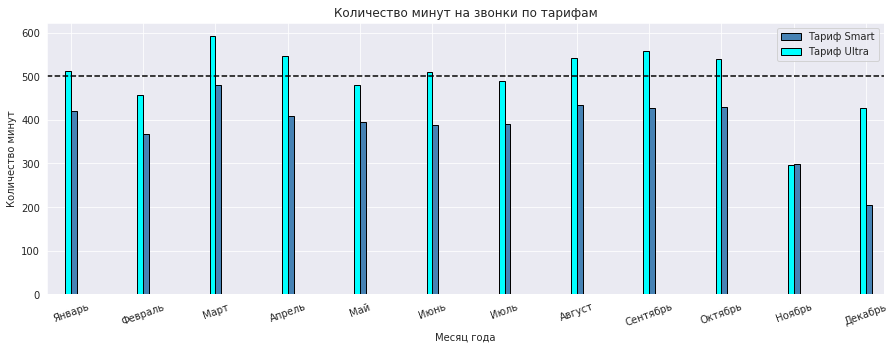

In [ ]:
quer = [mobile_customers.query('tariff == "smart"'), mobile_customers.query('tariff == "ultra"')]
plotting_mean_1(quer)


Мы рассмотрели средние значения по тарифам Smart и Ultra. В среднем, видно, что пользователи тарифа Ultra тратят больше минут на разговоры, но не значительно, при условии, что в тариф Ultra включено 3000 минут для разговоров. Возможно, снижение абонентской платы и уменьшение времени разговоров будет целесообразно.

In [ ]:
import plotly.express as px

fig = px.histogram(mobile_customers, 
                       x = 'duration_of_calls',
                       color = 'tariff', 
                       marginal = 'box',
                       opacity = 0.5, 
                       title = 'Распределение значений столбца duration_of_calls с разделением по тарифам')
fig.show()

Мы просмотрели изменения значений по месяцам в среднем. Посмотрим распределение продолжительности разговора по тарифам: Для построения будем использовать скрипичные диаграммы, что позволит увидеть распределения и плотности вероятностей. Создадим скрипичный сюжет:

In [ ]:
# выберем интересующие нас столбцы из дата сета
# исключим нулевые звонки
calls_mobile = mobile_customers [['tariff', 'duration_of_calls', 'user_id']].query('duration_of_calls > 0')
calls_mobile.head()

,tariff,duration_of_calls,user_id
0,ultra,408,1000
1,ultra,333,1000
2,ultra,340,1000
3,ultra,172,1000
4,ultra,159,1000


In [ ]:
fig = px.violin(
        calls_mobile, y='duration_of_calls', 
        x="tariff", color='tariff', box=True, points='all', 
        title = 'Скрипичная диаграмма времени разговора',
        labels={'duration_of_calls': 'Продолжительность разговора', 'tariff':'Тариф'}
        )
fig.show()

In [ ]:
# посчитаем среднее, стандартное отклонение, дисперсию и медиану для длительности звонков по тарифам
# для var ddof по умолчанию уже равен 1 (для выборки)

mc_call = mobile_customers.pivot_table(index='tariff',  
                 values='duration_of_calls', 
                 aggfunc=['mean', 'std', 'var', 'median'])
mc_call.columns = ['mean', 'std', 'var', 'median']
mc_call

,mean,std,var,median
tariff,,,,
smart,417.934948,190.313730,36219.315784,422
ultra,526.623350,317.606098,100873.633397,518


Мы видим, что длительность звонков по тарифам имеет скошенное распределение или положительное ассиметричное, стремиться к нормальному. У обоих тарифов мы видим длинный хвост выше медианы. Стоит отметить, что средняя продолжительность разговоров будет лежать выше медианы, при этом стоит отметить, что среднее у тарифа Ultra выше, соотвественно пользователи этих тарифов говорят по телефону чаще и дольше.  
Мы можем посчитать вероятное максимальное время разговор для обоих тарифов, чтобы понимать необходимое время включения в пакет. 

In [ ]:
# применим правило трех сигм и найдем вероятную верхнюю границу

smart_time = mc_call.loc ['smart', 'mean'] + 3*mc_call.loc ['smart', 'std']
ultra_time = mc_call.loc ['ultra', 'mean'] + 3*mc_call.loc ['ultra', 'std']
print('Вероятное максимальное время для тарифа Smart {:.0f} минут'.format (smart_time))
print('Вероятное максимальное время для тарифа Ultra {:.0f} минут'.format (ultra_time))

Вероятное максимальное время для тарифа Smart 989 минут
Вероятное максимальное время для тарифа Ultra 1479 минут


У тарифа Ультра включено в пакет 3000 минут, хотя вероятность использования его полностью мало, и чаще всего люди будут выговаривать 1479 минут. необходимо изучить возможность снижения предоплаченных минут в пакете за счет снижения абоненсткой платы. У тарифа Смарт, напротив - количество минут максимальное - 989, а пакет предоставляет только 500, хоть среднее значение и значится как 417 минут, возмжно стоит рассмотреть увеличинеи минут до 750, увеличив абонентскую плату

### Анализ количества сообщений

In [ ]:
smart_sms = mobile_customers.query('tariff == "smart"')['quantity_of_sms'].reset_index(drop=True).round(0)

smart_sms_var = np.var(smart_sms, ddof=1)

# для удобства решили вынести расчет std отдельно, считаем для выборки, ddof=1

smart_sms_dev = np.std (smart_sms, ddof=1)


print('Тариф Smart')
print()
print('Дисперсия по sms тарифа SMART: {:.2f}'.format(smart_sms_var))
print('Cтандартное отклонение по выборке sms тарифа SMART: {:.2f}'.format(smart_sms_dev))
print()
print(smart_sms.describe().T)



Тариф Smart

Дисперсия по sms тарифа SMART: 796.81
Cтандартное отклонение по выборке sms тарифа SMART: 28.23

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: quantity_of_sms, dtype: float64


In [ ]:
mobile_customers.pivot_table(index='tariff',  
                 values=['duration_of_calls', 'quantity_of_sms', 'gb_used_total'], 
                 aggfunc=['mean', 'std', 'var']).T.style.format('{:.2f}')

In [ ]:
ultra_sms = mobile_customers.query('tariff == "ultra"')['quantity_of_sms'].reset_index(drop=True).round(0)

ultra_sms_var = np.var(ultra_sms, ddof=1)

# для удобства решили вынести расчет std отдельно, считаем для выборки, ddof=1

ultra_sms_dev = np.std (ultra_sms, ddof=1)


print('Тариф Ultra')
print()
print('Дисперсия по sms тарифа Ultra: {:.2f}'.format(ultra_sms_var))
print('Cтандартное отклонение по выборке sms тарифа Ultra: {:.2f}'.format(ultra_sms_dev))
print()
print(ultra_sms.describe().T)



Тариф Ultra

Дисперсия по sms тарифа Ultra: 2285.27
Cтандартное отклонение по выборке sms тарифа Ultra: 47.80

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: quantity_of_sms, dtype: float64


Посмотрим какие значения в среднем по тарифам относительно друг друга:

In [ ]:
#напишем функцию для построения диаграммы

def plotting_mean_2(d_list, query=None):
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    ax1 = plt.gca()
    
    list_of_colors = ['lightseagreen', 'aquamarine']
    names_for_legend = ['Тариф Smart', 'Тариф Ultra']
    legend_list = []

    for i in range(len(d_list)):
        gr_df = d_list[i]
        gr_df_p = gr_df.groupby(
                    ['tariff','month_name']).agg({'quantity_of_sms':'mean'}).reset_index().round(0)

        plot = gr_df_p.plot(x='month_name', y='quantity_of_sms', kind='bar', edgecolor='black', color=list_of_colors[i],
                                 ax=ax, width=0.08, position=i)
        legend_list.append(names_for_legend [i])
        
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
                      ['Январь', 'Февраль','Март', 'Апрель', 
                       'Май', 'Июнь'                       , 'Июль','Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'],
                    rotation=20)
    ax.legend(legend_list)
    ax1.hlines(y=50, linestyle='--', color='black', xmin=-1, xmax=12)
    
    plt.title('Количество смс сообщений в месяц')
    plt.xlabel('Месяц года')
    plt.ylabel('Количество сообщений')
    plt.show()

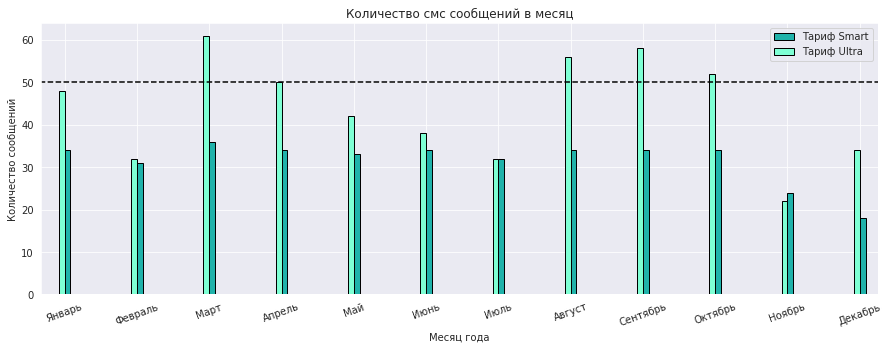

In [ ]:
plotting_mean_2(quer)

В среднем, пользователи тарифов укладываются в лимиты, при этом пользователи тарифа Ultra расходуют меньше sms-сообщений, чем ими оплачено. Снижение абонентской платы за счет снижения предоплаченных sms-сообщений может помочь продвижению и популяризации тарифа.

Мы просмотрели изменения значений по месяцам в среднем. Посмотрим распределение sms-сообщений по тарифам: Для построения будем использовать скрипичные диаграммы, что позволит увидеть распределения и плотности вероятностей. Создадим скрипичный сюжет:

In [ ]:
# выберем интересующие нас столбцы из дата сета
# исключим нулевые отправки sms
sms_mobile = mobile_customers [['tariff', 'quantity_of_sms', 'user_id']].query('quantity_of_sms > 0')
sms_mobile.head()

,tariff,quantity_of_sms,user_id
0,ultra,81,1000
1,ultra,70,1000
2,ultra,75,1000
3,ultra,60,1000
4,ultra,22,1000


In [ ]:
fig = px.violin(
        sms_mobile, y='quantity_of_sms', 
        x="tariff", color='tariff', box=True, points='all', 
        title = 'Скрипичная диаграмма sms-сообщений',
        labels={'quantity_of_sms': 'Количество sms', 'tariff':'Тариф'}
        )
fig.show()

In [ ]:
# посчитаем среднее, стандартное отклонение, дисперсию и медиану для sms по тарифам
# для var ddof по умолчанию уже равен 1 (для выборки)

mc_sms = mobile_customers.pivot_table(index='tariff',  
                 values='quantity_of_sms', 
                 aggfunc=['mean', 'std', 'var', 'median'])
mc_sms.columns = ['mean', 'std', 'var', 'median']
mc_sms

,mean,std,var,median
tariff,,,,
smart,33.384029,28.227876,796.812958,28
ultra,49.363452,47.804457,2285.266143,38


Мы видим, количество sms по тарифам имеет скошенное распределение или положительное ассиметричное, стремиться к нормальному. У обоих тарифов мы видим длинный хвост выше медианы.  
Мы можем посчитать вероятное максимальное количество sms для обоих тарифов. Вероятность, что люди буду отправлять больше минимальная 

In [ ]:
# применим правило трех сигм и найдем вероятную верхнюю границу

smart_sms = mc_sms.loc ['smart', 'mean'] + 3*mc_sms.loc ['smart', 'std']
ultra_sms = mc_sms.loc ['ultra', 'mean'] + 3*mc_sms.loc ['ultra', 'std']
print('Вероятное максимальное количество sms для тарифа Smart {:.0f} шт.'.format (smart_sms))
print('Вероятное максимальное количество sms для тарифа Ultra {:.0f} шт.'.format (ultra_sms))

Вероятное максимальное количество sms для тарифа Smart 118 шт.
Вероятное максимальное количество sms для тарифа Ultra 193 шт.


Снова мы видим, что тариф Ultra имеет слишком большой пакет для sms. У Смарта значения среднего попадает под пакет. Люди, которые тратят смс сверх пакета могут перейти на тариф Ультра, при этом его привлекательность можно повысить снижением количество предоплаченных sms сообщений, и снижение абонетской платы

### Анализ интернет-траффика

In [ ]:
smart_traf = mobile_customers.query('tariff == "smart"')['gb_used_total'].reset_index(drop=True).round(0)

smart_traf_var = np.var(smart_traf, ddof=1)

# для удобства решили вынести расчет std отдельно, считаем для выборки, ddof=1

smart_traf_dev = np.std (smart_traf, ddof=1)


print('Тариф Smart')
print()
print('Дисперсия по потраченному интернет-траффику тарифа SMART: {:.2f}'.format(smart_traf_var))
print('Cтандартное отклонение по выборке интернет траффика тарифа SMART: {:.2f}'.format(smart_traf_dev))
print()
print(smart_traf.describe().T)



Тариф Smart

Дисперсия по потраченному интернет-траффику тарифа SMART: 32.99
Cтандартное отклонение по выборке интернет траффика тарифа SMART: 5.74

count    2229.000000
mean       15.834006
std         5.743804
min         0.000000
25%        12.000000
50%        16.000000
75%        20.000000
max        38.000000
Name: gb_used_total, dtype: float64


In [ ]:
ultra_traf = mobile_customers.query('tariff == "ultra"')['gb_used_total'].reset_index(drop=True).round(0)

ultra_traf_var = np.var(ultra_traf, ddof=1)

# для удобства решили вынести расчет std отдельно, считаем для выборки, ddof=1

ultra_traf_dev = np.std (ultra_traf, ddof=1)


print('Тариф Ultra')
print()
print('Дисперсия по потраченному интернет-траффику тарифа Ultra: {:.2f}'.format(ultra_traf_var))
print('Cтандартное отклонение по выборке интернет траффика тарифа Ultra: {:.2f}'.format(ultra_traf_dev))
print()
print(ultra_traf.describe().T)



Тариф Ultra

Дисперсия по потраченному интернет-траффику тарифа Ultra: 97.50
Cтандартное отклонение по выборке интернет траффика тарифа Ultra: 9.87

count    985.000000
mean      19.032487
std        9.874052
min        0.000000
25%       12.000000
50%       19.000000
75%       26.000000
max       49.000000
Name: gb_used_total, dtype: float64


In [ ]:
#напишем функцию для построения диаграммы

def plotting_mean_3(d_list, query=None):
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    ax1 = plt.gca()
    ax2 = plt.gca()
    
    list_of_colors = ['wheat', 'teal']

    names_for_legend = ['Тариф Smart', 'Тариф Ultra']
    legend_list = []

    for i in range(len(d_list)):
        gr_df = d_list[i]
        gr_df_p = gr_df.groupby(
                    ['tariff','month_name']).agg({'gb_used_total':'mean'}).reset_index().round(0)

        plot = gr_df_p.plot(x='month_name', y='gb_used_total', kind='bar', edgecolor='black', color=list_of_colors[i],
                                 ax=ax, width=0.08, position=i)
        legend_list.append(names_for_legend [i])
        
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
                      ['Январь', 'Февраль','Март', 'Апрель', 
                       'Май', 'Июнь'                       , 'Июль','Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'],
                    rotation=20)
    ax.legend(legend_list)
    ax1.hlines(y=15, linestyle='--', color='black', xmin=-1, xmax=12)
    ax2.hlines(y=30, linestyle='--', color='black', xmin=-1, xmax=12)
    plt.title('Количество использованного интернет траффика в месяц')
    plt.xlabel('Месяц года')
    plt.ylabel('Количество гигабайт')
    plt.show()

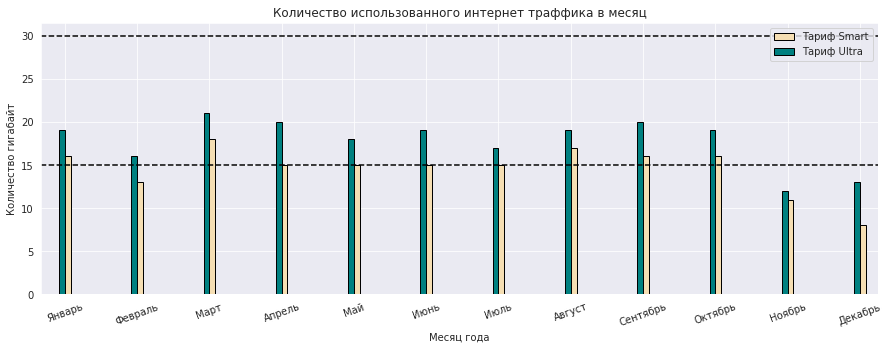

In [ ]:
plotting_mean_3(quer)


В среднем по тарифу Smart есть превышения траффика, тогда как Ultra укладывается в отведенный лимит. Здесь можно предложить увеличить пакет Гигабайт для пользователей тарифа Smart, при этом увеличив абонентскую плату, а для тарифа Ultra снизить пакет - что снизит и стоимость для клиента. Необходимо провести дополнительные исследования, например - через опрос потребителей.

Мы просмотрели изменения значений по месяцам в среднем. Посмотрим распределение траффика по тарифам: Для построения будем использовать скрипичные диаграммы, что позволит увидеть распределения и плотности вероятностей. Создадим скрипичный сюжет:

In [ ]:
# выберем интересующие нас столбцы из дата сета
# исключим нулевые значения
intertnet_mobile = mobile_customers [['tariff', 'gb_used_total', 'user_id']].query('gb_used_total > 0')
intertnet_mobile['gb_used_total'] = intertnet_mobile ['gb_used_total'].round(2)
intertnet_mobile.head()

,tariff,gb_used_total,user_id
0,ultra,13.74,1000
1,ultra,9.60,1000
2,ultra,13.69,1000
3,ultra,22.71,1000
4,ultra,2.20,1000


In [ ]:
fig = px.violin(
        intertnet_mobile, y='gb_used_total', 
        x="tariff", color='tariff', box=True, points='all', 
        title = 'Скрипичная диаграмма интернет траффика',
        labels={'gb_used_total': 'Количеств Gb', 'tariff':'Тариф'}
        )
fig.show()

In [ ]:
# посчитаем среднее, стандартное отклонение, дисперсию и медиану для траффика по тарифам
# для var ddof по умолчанию уже равен 1 (для выборки)

mc_internet = mobile_customers.pivot_table(index='tariff',  
                 values='gb_used_total', 
                 aggfunc=['mean', 'std', 'var', 'median'])
mc_internet.columns = ['mean', 'std', 'var', 'median']
mc_internet

,mean,std,var,median
tariff,,,,
smart,15.848817,5.739821,32.945548,16.143555
ultra,19.030177,9.859685,97.213384,18.871094


Мы видим, количество траффика по тарифам имеет скошенное распределение или положительное ассиметричное, стремиться к нормальному. У обоих тарифов мы видим длинный хвост выше медианы.  
Мы можем посчитать вероятное максимальное количество траффика для обоих тарифов. Вероятность, что люди будут использовать больше - минимальная 

In [ ]:
# применим правило трех сигм и найдем вероятную верхнюю границу

smart_int = mc_internet.loc ['smart', 'mean'] + 3*mc_internet.loc ['smart', 'std']
ultra_int = mc_internet.loc ['ultra', 'mean'] + 3*mc_internet.loc ['ultra', 'std']
print('Вероятное максимальное количество Gb для тарифа Smart {:.0f} Gb'.format (smart_int))
print('Вероятное максимальное количество Gb для тарифа Ultra {:.0f} Gb'.format (ultra_int))

Вероятное максимальное количество Gb для тарифа Smart 33 Gb
Вероятное максимальное количество Gb для тарифа Ultra 49 Gb


По всем тарифам максимальные вероятные значения лежат выше пакета, при этом у Smart даже среднее выходит за пакет. Вероятнее, надо рассмотреть увеличение траффика, за счет снижения пакета sms

### Выводы

Анализ средних показателей показал, что тариф Smart больше оптимизирован, а Ultra имеет слишком завышенные параметры. При этом и тарифу Smart требуется дополнительная настройка - пользователи докупают слишком много траффика. Включение его в абонентскую плату хоть и повысит его стоимость, но при этом избавит абонента от перерасхода и покупки дополнительных услуг. Сохранить текущие размеры абонентской платы можно за счет снижения количества sms или минут для данного тарифа. Тариф Ультра требует донастройки. Снижение абонентской платы может сделать его более привлекательным для потребителя. При этом тарифу можно снизить количество минут, и повысить траффик

## Построение гипотез




### Средняя выручка по Москве и регионам

In [ ]:
mobile_customers.head(10)

,user_id,month_name,duration_of_calls,quantity_of_calls,quantity_of_sms,gb_used_total,tariff,city,minutes_over_plan,sms_over_plan,gb_over_plan,monthly_overcome,monthly_revenue
0,1000,Август,408,42,81,13.740234,ultra,Краснодар,0,0,0,0.0,1950
1,1000,Декабрь,333,38,70,9.596680,ultra,Краснодар,0,0,0,0.0,1950
2,1000,Июль,340,41,75,13.687500,ultra,Краснодар,0,0,0,0.0,1950
3,1000,Июнь,172,28,60,22.711914,ultra,Краснодар,0,0,0,0.0,1950
4,1000,Май,159,17,22,2.203125,ultra,Краснодар,0,0,0,0.0,1950
5,1000,Ноябрь,338,37,58,14.421875,ultra,Краснодар,0,0,0,0.0,1950
6,1000,Октябрь,350,44,73,14.372070,ultra,Краснодар,0,0,0,0.0,1950
7,1000,Сентябрь,466,46,57,14.239258,ultra,Краснодар,0,0,0,0.0,1950
8,1001,Ноябрь,430,45,0,18.019531,smart,Москва,0,0,3,800.0,1350
9,1001,Декабрь,414,47,0,13.723633,smart,Москва,0,0,0,0.0,550


Проверим как отличается средняя выручка по Москве и регионам.  
Построим гипотезы:
 Сформулируем ее как Гипотезу о равенстве средних двух генеральных совокупностей
 - **H0 (нулевая гипотеза)**: средняя выручка абонентов из Москвы **равна** средней выручке абонентов из других регионов.
   
 - **H1 (альтернативная гипотеза)**:  средняя выручка абонентов из Москвы **не равна** средней выручке абонентов из других регионов.  
 
 
 Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, примените метод `scipy.stats.ttest_ind (array1, array2, equal_var)`, при этом критический уровень статистической значимости alpha принимаем как .05

Для начала оценим наши выборки. Это позволит нам выяснить какой параметр `equal_var` нам применять в тест Стьюдента. Проведем тест Левена и рассмотрим различатся ли дисперсии наших выборок.

In [ ]:
# сделаем выборки

mosсow_abonents = mobile_customers.query('city == "Москва"')
region_abonents = mobile_customers.query('city != "Москва"')

# создадим списки самплов

sample_1 = mosсow_abonents['monthly_revenue'].tolist()
sample_2 = region_abonents['monthly_revenue'].tolist()
alpha = .05
stat, p = st.levene(sample_1, sample_2)
result_levene = p

# проведем тест Левена

if result_levene < alpha:
    print('Отвергаем Н0, дисперсии различаются, equal_var=False для ttest')
else:
    print("Не отвергаем Н0, дисперсии не различаются, equal_var=True для ttest")

var_sample = [np.var(x, ddof=1) for x in [sample_1, sample_2]]
print('Дисперсии по выборкам: ', var_sample)


Отвергаем Н0, дисперсии различаются, equal_var=False для ttest
Дисперсии по выборкам:  [566183.0292184273, 656766.5955122437]


In [ ]:
# Проведем ttest, equal_var=False

alpha = .05 
results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем Н0")
else:
    print("Не отвергаем Н0")




p-значение: 0.5126564657748214
Не отвергаем Н0


Гипотеза: средняя выручка абонентов из Москвы равна средней выручке абонентов из других регионов - имеет право быть. Посчитаем среднюю по выборке:

In [ ]:
print('Средняя выручка по абоненту в месяц в Москве: {:.2f}'.format(mosсow_abonents ['monthly_revenue'].mean()))
print('Средняя выручка по абоненту в регионах: {:.2f}'.format(region_abonents ['monthly_revenue'].mean()))

Средняя выручка по абоненту в месяц в Москве: 1550.81
Средняя выручка по абоненту в регионах: 1528.32


Действительно, средняя выручка по выборке для Москвы и регионом примерно одинаково. Утверждать, что в Москве платят больше - мы не можем

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Аналогично п. 4.1:

Проверим как отличается средняя выручка пользователей тарифов «Ультра» и «Смарт»:

H0 (нулевая гипотеза): средняя выручка пользователей тарифов «Ультра» и «Смарт» **равна**.

H1 (альтернативная гипотеза): средняя выручка пользователей тарифов «Ультра» и «Смарт» **не равна**.

Аналогично, чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, примените метод scipy.stats.ttest_ind (array1, array2, equal_var), при этом критический уровень статистической значимости alpha принимаем как .05

Для начала оценим наши выборки. Это позволит нам выяснить какой параметр `equal_var` нам применять в тест Стьюдента. Проведем тест Левена и рассмотрим различатся ли дисперсии наших выборок.

In [ ]:
# сделаем выборки
smart_abonents = mobile_customers.query('tariff == "smart"')
ultra_abonents = mobile_customers.query('tariff == "ultra"')

# создадим списки самплов

sample_01 = smart_abonents['monthly_revenue'].tolist()
sample_02 = ultra_abonents['monthly_revenue'].tolist()
alpha = .05

# проведем тест Левена

stat1, p1 = st.levene(sample_01, sample_02)
result_levene_1 = p1

if result_levene_1 < alpha:
    print('Отвергаем Н0, дисперсии различаются, equal_var=False для ttest')
else:
    print("Не отвергаем Н0, дисперсии не различаются, equal_var=True для ttest")

var_sample1 = [np.var(x, ddof=1) for x in [sample_01, sample_02]]
print('Дисперсии по выборкам: ', var_sample1)


Отвергаем Н0, дисперсии различаются, equal_var=False для ttest
Дисперсии по выборкам:  [673931.3213632443, 143491.24055961374]


In [ ]:
# проведем ttest, equal_var=False
alpha = .05 
results1 = st.ttest_ind(sample_01, sample_02, equal_var=False)

print('p-значение:', results1.pvalue)

if results1.pvalue < alpha:
    print("Отвергаем Н0")
else:
    print("Не отвергаем Н0")



p-значение: 2.7240946993530856e-246
Отвергаем Н0


In [ ]:
print('Средняя выручка по абоненту тарифа Смарт: {:.2f}'.format(smart_abonents ['monthly_revenue'].mean()))
print('Средняя выручка по абоненту Тарифа Ультра: {:.2f}'.format(ultra_abonents ['monthly_revenue'].mean()))

Средняя выручка по абоненту тарифа Смарт: 1294.64
Средняя выручка по абоненту Тарифа Ультра: 2071.07


Отберем уникальные значения по тарифам и выручке

In [ ]:
all_abonents = mobile_customers [['tariff', 'monthly_revenue']]
all_abonents_unique = all_abonents.drop_duplicates().reset_index(drop=True)
all_abonents_unique.head()

,tariff,monthly_revenue
0,ultra,1950
1,smart,1350
2,smart,550
3,smart,1550
4,smart,1150


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



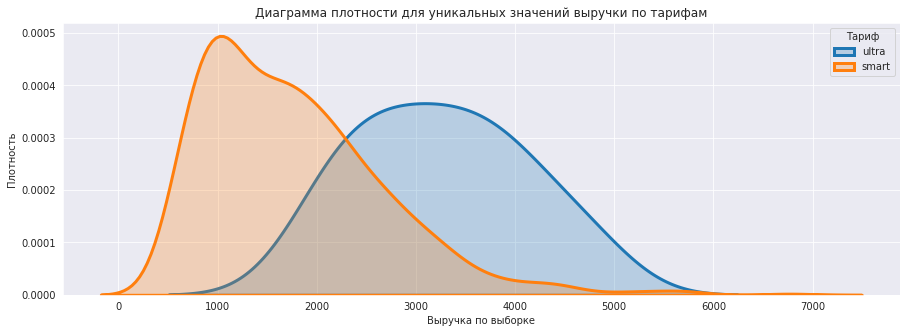

In [ ]:
# Построим диаграмму плотности для обоих тарифов по выборке уникальных значений
tar = ['ultra', 'smart']
figdims = (15,5)
plt.subplots(figsize=figdims)
for tariff in tar:

    subset = all_abonents_unique[all_abonents_unique['tariff'] == tariff]
    sns.distplot(
                subset['monthly_revenue'], hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 3}, 
                label = tariff
                )
    


plt.legend(prop={'size': 10}, title = 'Тариф')
plt.title('Диаграмма плотности для уникальных значений выручки по тарифам')
plt.xlabel('Выручка по выборке')
plt.ylabel('Плотность')
plt.show()

Нулевую гипотезу отвергаем. Измерение показателей средней выручки показывают, что абоненты тарифа Ультра в месяц платят больше

### Вывод

Результаты проверок наших гипотез: 
  
- средняя выручка абонентов из Москвы равна средней выручке абонентов из других регионов
- средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна

## Вывод

Мы проанализировали два тарифных плана: **«Смарт»** и **«Ультра»** и провели предварительный анализ тарифов на небольшой выборке клиентов.   


Анализ средних показателей показал, что тариф Smart больше оптимизирован, относительно Ultra, который имеет слишком завышенные параметры. Смарт популярнее, дешевле, но абоненты чаще докупают дополнительные услуги. Стоит рассмотреть дополнительную настройку тарифа:

- повысить количество доступных базовых гигабайт, за счет увеличения абонентской платы
- повысить количество доступных минут, за счет увеличения абонетской платы


Напротив, для тарифа Ultra возможно стоит расмотреть снижения доступных услуг, при этом понизив абонентскую плату. Либо рассмотреть возможность появления нового, промежуточного тарифа, например - **Optima**, который будет промежуточным вариантом среди двух существующих


**На данном этапе, считаем что компании необходимо произвести донастройку тарифа Ultra и повысить его привлекательность. Тариф Ультра имеет достаточный разброс показателей для настройки, снижения абонентской платы, что может сделать его привлекательнее для потребителя**










